----- Basic QAQC -----
Data Shape: (4771, 13)

First 5 Rows:
   unique_id    holeid  from     to  as        au       pb       fe        mo  \
0    A04812  SOLVE003   561  571.0 NaN  0.066000  1031.00  61380.0  138.2000   
1    A03356  SOLVE003   571  581.0 NaN  0.152000  1982.00  50860.0   75.4000   
2    A04764  SOLVE003   581  591.0 NaN  0.068000  1064.80  57940.0   29.2000   
3    A04626  SOLVE003   591  601.0 NaN  0.074000   891.60  48620.0   63.0000   
4    A05579  SOLVE003   601  611.0 NaN  0.043125   801.25  51025.0   56.0625   

      cu          s       zn class  
0  3.600  3586.0000  43.6000     A  
1  4.800  1822.0000  36.4000     A  
2  3.000   740.4000  36.6000     A  
3  4.200   820.8000  39.6000     A  
4  4.875   745.6875  32.3125     A  

Number of duplicate 'unique_id' entries: 0

Missing Values (per column):
 unique_id       0
holeid          0
from            0
to              0
as           1503
au            470
pb             15
fe             62
mo             5

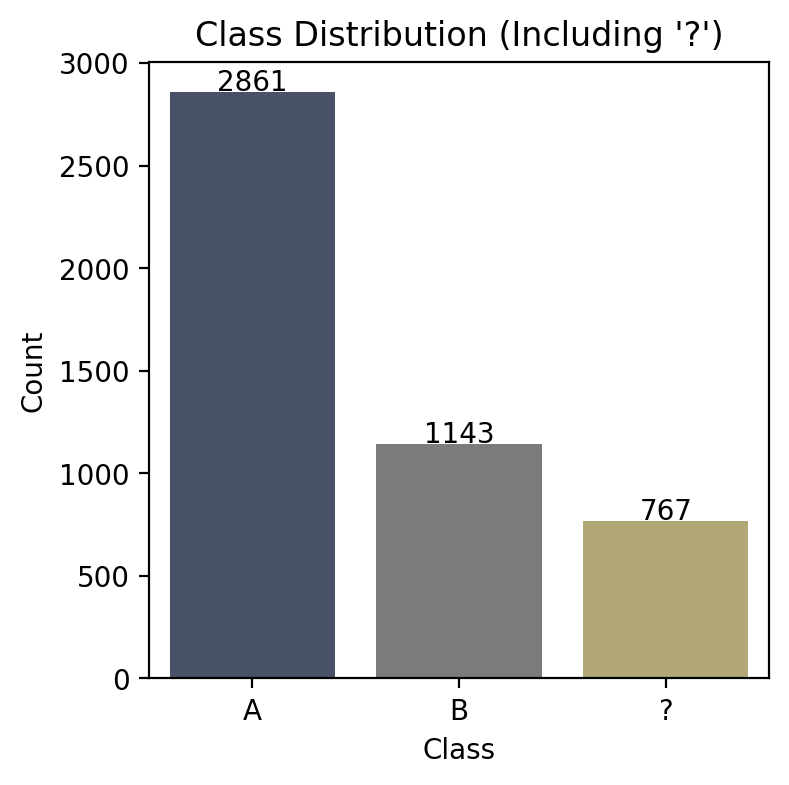

/Users/zuhair/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zuhair/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zuhair/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zuhair/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

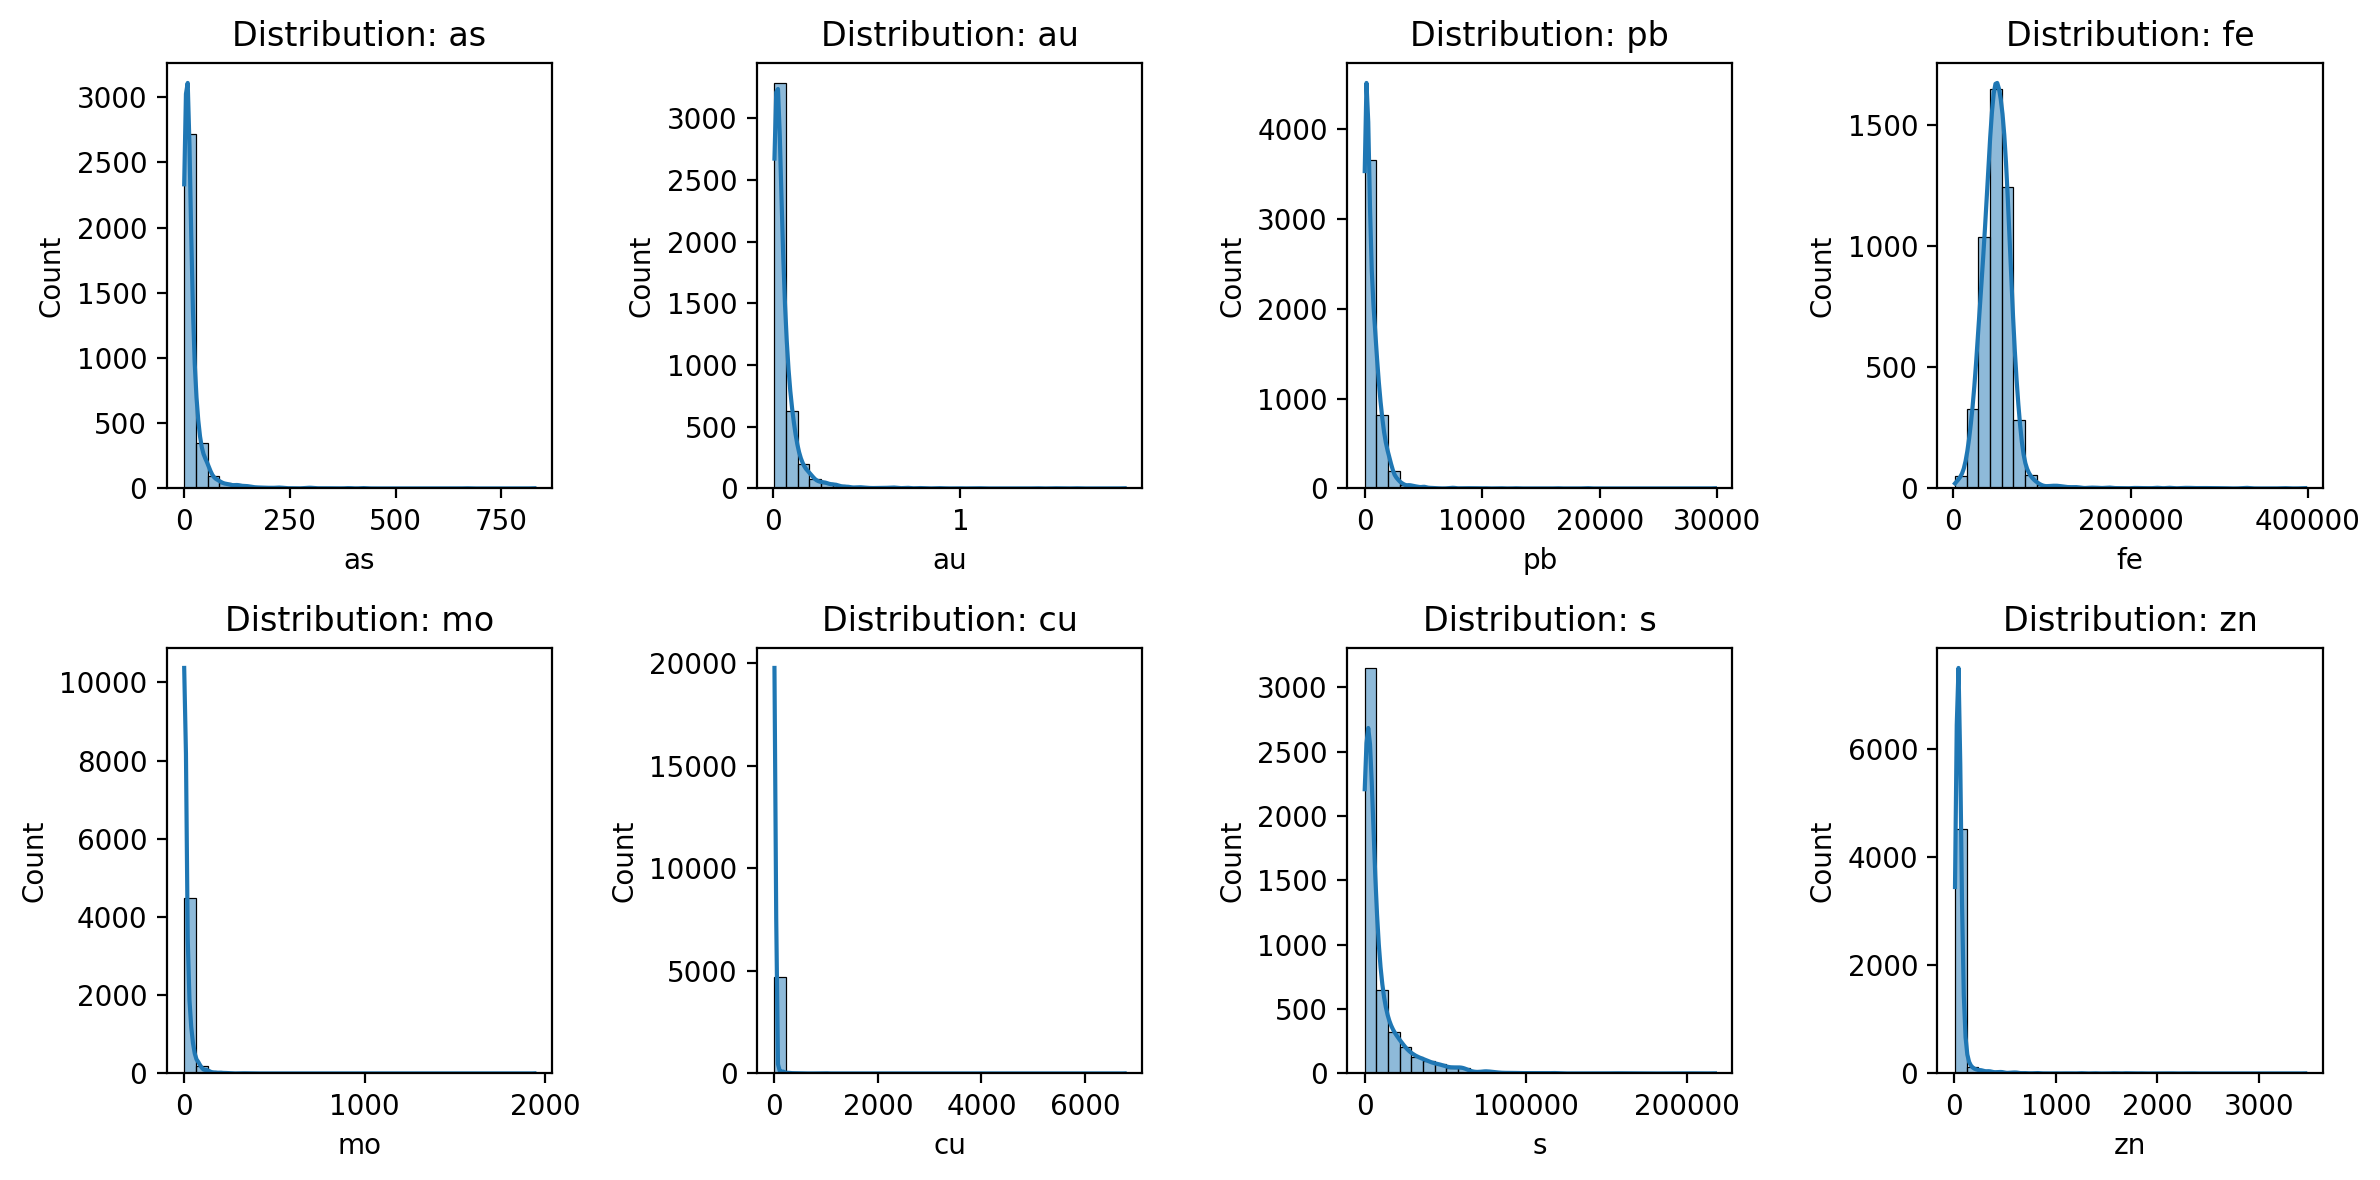

----- Training Model with XGBoost + GridSearchCV + scale_pos_weight -----
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 100, 'clf__reg_alpha': 1, 'clf__reg_lambda': 1, 'clf__scale_pos_weight': 1}
Best CV Score (Train): 0.8573
------------------------------------------------------

--- TRAIN Classification Report ---
              precision    recall  f1-score   support

           0     0.9618    0.9799    0.9708      2289
           1     0.9472    0.9026    0.9244       914

    accuracy                         0.9579      3203
   macro avg     0.9545    0.9413    0.9476      3203
weighted avg     0.9577    0.9579    0.9575      3203

TRAIN Confusion Matrix:
 [[2243   46]
 [  89  825]] 

--- TEST Classification Report ---
              precision    recall  f1-score   support

           0     0.8887    0.9353    0.9114       572
           1     0.8141    0.7074    0.7570       22

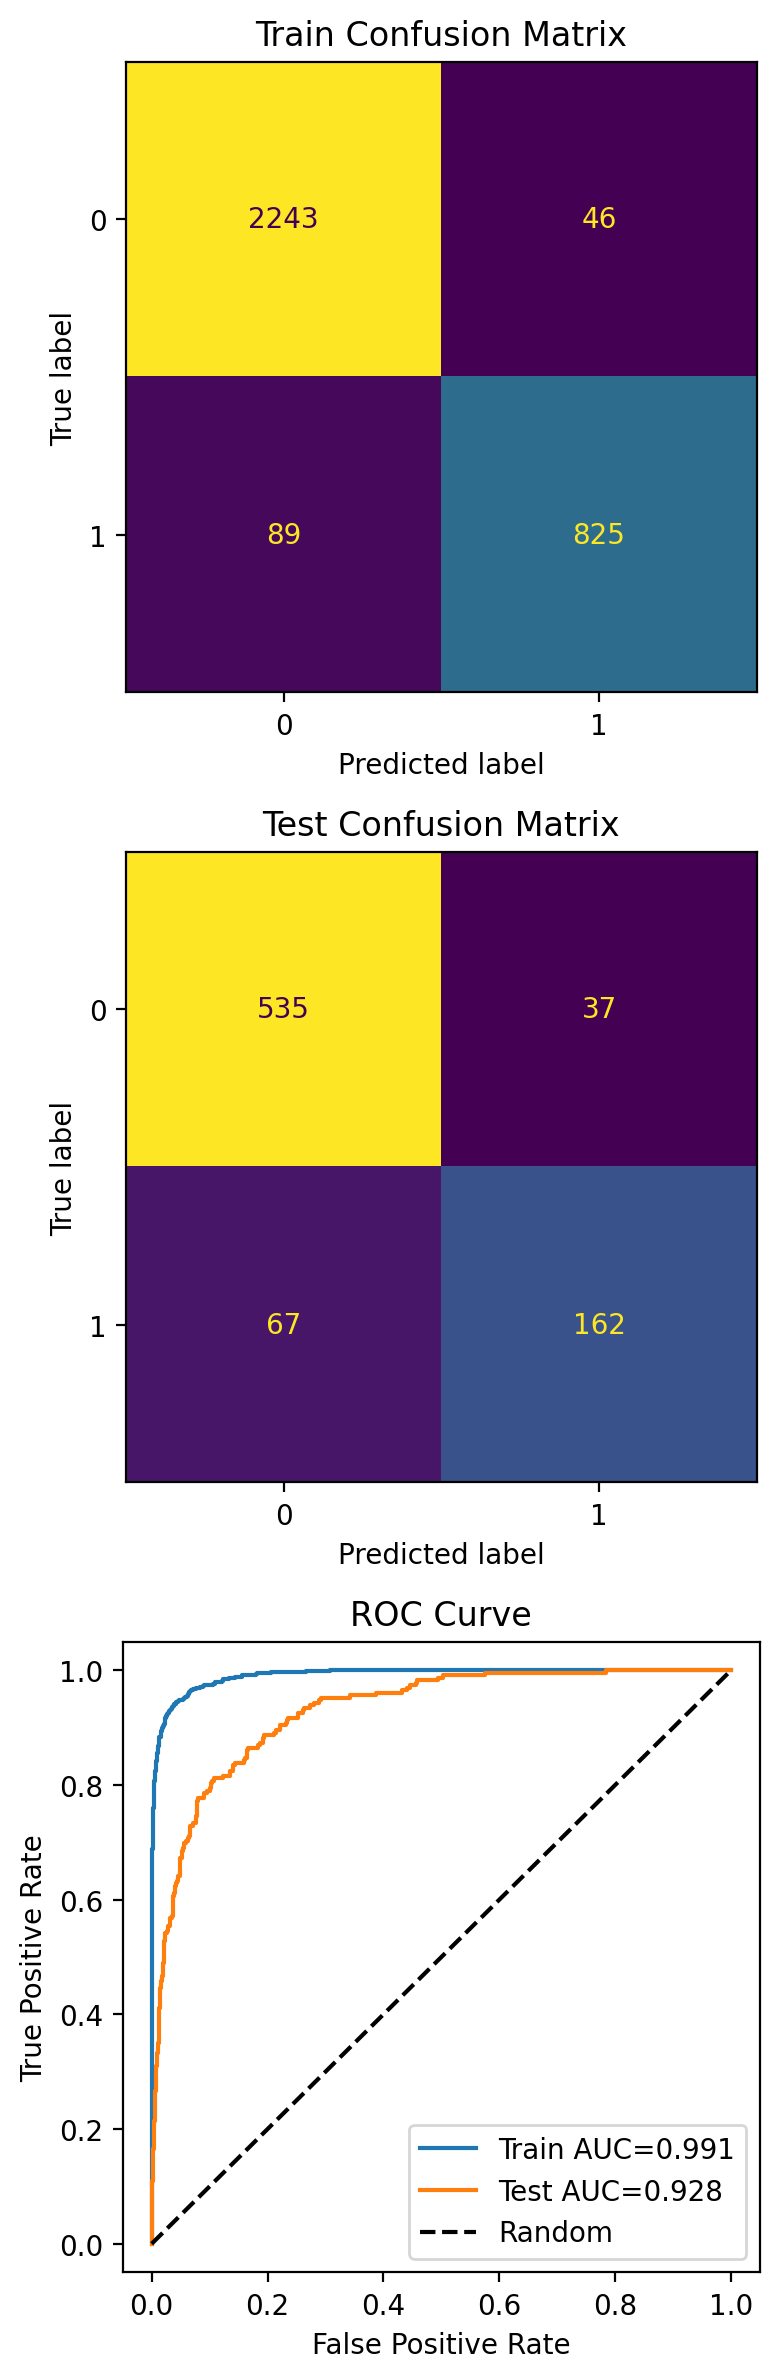

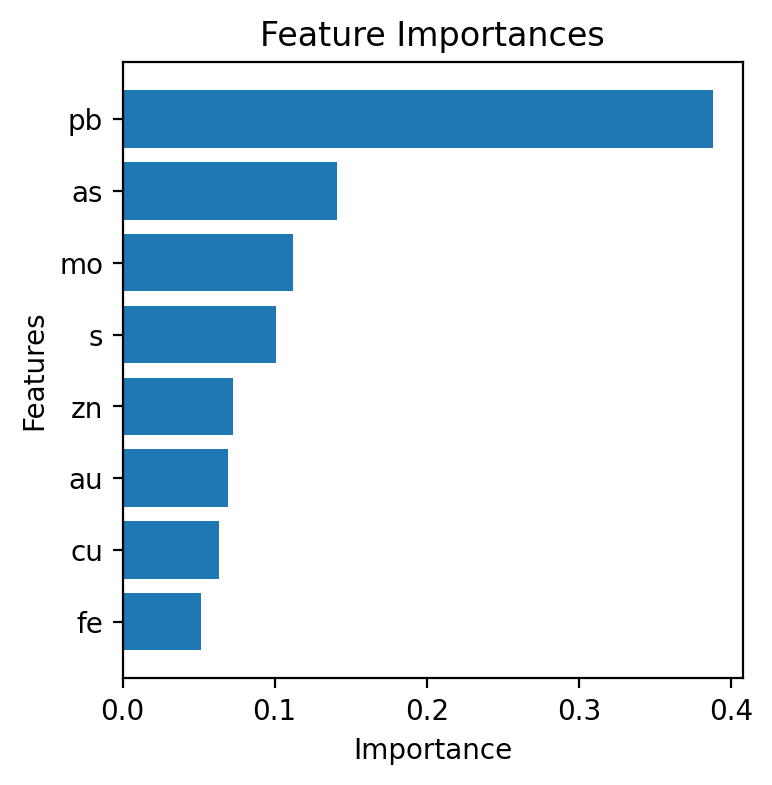


Predictions for unlabeled data have been assigned:
class
B    402
A    365
Name: count, dtype: int64

Updated data with new predictions saved to xgb_predictions.csv


In [3]:
"""
Datarock's Broken Down Lead Deposit Classification using XGBoost
with Train/Test Split, Confusion Matrix, ROC, Feature Importances,
and class imbalance handling via scale_pos_weight
=================================================================

Author: Mohd Zuhair
Date: 03-02-2025

Description:
------------
This script demonstrates an end-to-end workflow:
    1. Data ingestion & QAQC
    2. Exploratory Data Analysis (EDA)
    3. Feature Engineering / Handling Missing Values
    4. Model Training using XGBoost
    5. Model Evaluation (Cross-Validation on Train) + Train/Test Classification Reports
    6. Confusion Matrix, ROC Curves, Feature Importance Plot
    7. Prediction for Unlabeled Data (Class='?')

Imbalance Handling:
-------------------
I add 'scale_pos_weight' to the hyperparameter grid for XGBoost. This tells XGBoost
to pay more attention to the minority (positive) class.

"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

# For model building & evaluation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV,
    train_test_split
)
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, roc_auc_score, ConfusionMatrixDisplay
)
from xgboost import XGBClassifier

# ---------------------------------------------------------------------------
# 1. DATA INGESTION & QAQC
# ---------------------------------------------------------------------------

def load_and_combine_data(data_path):
    """
    Loads geochemical data from CSV, replaces sentinel values (-999) with NaN,
    and converts known numeric columns to float.
    """
    df = pd.read_csv(data_path)
    
    # Replace sentinel values
    df = df.replace(-999, np.nan)
    df = df.replace("-999", np.nan)
    
    # Convert columns to numeric if they exist
    numeric_cols = ['As','Au','Pb','Fe','Mo','Cu','S','Zn']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Lowercase column names for consistency
    df.columns = [col.lower() for col in df.columns]
    
    return df

def basic_qaqc(df):
    """
    Prints out basic QAQC info: shape, head, duplicates, missing values, class distribution.
    """
    print("----- Basic QAQC -----")
    print(f"Data Shape: {df.shape}")
    print("\nFirst 5 Rows:\n", df.head())
    
    # Duplicates in 'unique_id' if present
    if 'unique_id' in df.columns:
        duplicates = df['unique_id'].duplicated().sum()
        print(f"\nNumber of duplicate 'unique_id' entries: {duplicates}")
    
    # Missing values
    missing_per_col = df.isnull().sum()
    print("\nMissing Values (per column):\n", missing_per_col)
    
    # Class distribution
    if 'class' in df.columns:
        class_counts = df['class'].value_counts(dropna=False)
        print("\nClass Distribution:\n", class_counts)
    print("------------------------------------------------\n")

# ---------------------------------------------------------------------------
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# ---------------------------------------------------------------------------

def eda(df):
    """
    Basic EDA: summary stats, histograms, correlation matrix.
    """
    print("----- Exploratory Data Analysis -----\n")
    
    numeric_cols = ['as','au','pb','fe','mo','cu','s','zn']
    print("Statistical Summary of Numeric Columns:\n", df[numeric_cols].describe())
    
        # Plot class distribution (A, B, ?)
    if 'class' in df.columns:
        class_counts = df['class'].value_counts(dropna=False)
        
        plt.figure(figsize=(4,4), dpi=200)
        sns.barplot(x=class_counts.index, y=class_counts.values, palette='cividis')
        plt.title("Class Distribution (Including '?')")
        plt.xlabel("Class")
        plt.ylabel("Count")
        for i, v in enumerate(class_counts.values):
            plt.text(i, v + 5, str(v), ha='center')  # add counts above bars
        plt.show()
    
    # Histograms
    fig, axes = plt.subplots(2, 4, figsize=(12,6), dpi=200)
    axes = axes.flatten()
    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col], kde=True, ax=axes[i], bins=30)
        axes[i].set_title(f"Distribution: {col}")
    plt.tight_layout()
    plt.show()
    

# ---------------------------------------------------------------------------
# 3. DATA PREPARATION & FEATURE ENGINEERING
# ---------------------------------------------------------------------------

def prepare_data_for_model(df):
    """
    Splits the dataset into labeled (A/B) and unlabeled (?).
    Maps A->0, B->1 for supervised learning.
    
    Returns:
      X_labeled, y_labeled, X_unlabeled, df_unlabeled_indices
    """
    feature_cols = ['as','au','pb','fe','mo','cu','s','zn']
    
    # Separate labeled vs unlabeled
    df_labeled = df[df['class'].isin(['A','B'])].copy()
    df_unlabeled = df[df['class'] == '?'].copy()
    
    # Map labels to 0/1
    label_map = {'A': 0, 'B': 1}
    df_labeled['class'] = df_labeled['class'].map(label_map)
    
    X_labeled = df_labeled[feature_cols]
    y_labeled = df_labeled['class']
    
    # Store unlabeled for later predictions
    X_unlabeled = df_unlabeled[feature_cols]
    df_unlabeled_indices = df_unlabeled.index
    
    return X_labeled, y_labeled, X_unlabeled, df_unlabeled_indices

# ---------------------------------------------------------------------------
# 4. MODEL TRAINING & EVALUATION (XGBoost)
# ---------------------------------------------------------------------------

def train_and_evaluate_model(X, y):
    """
    1. Splits labeled data (X, y) into train/test.
    2. Builds a Pipeline [Imputer -> Scaler -> XGBClassifier].
    3. Uses GridSearchCV with StratifiedKFold for hyperparameter tuning on the TRAIN set.
    4. Prints best params, classification reports, confusion matrices, ROC, feature importances.
    5. Returns the best pipeline (fit on entire train) and data splits.
    
    I incorporate 'scale_pos_weight' in the grid to handle class imbalance.
    """
    
    # (1) Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # (2) Build pipeline
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('clf', XGBClassifier(
            random_state=42,
            eval_metric='logloss',
            n_jobs=-1
        ))
    ])
    
    # (3) Hyperparameter grid + cross-validation
    # Added 'clf__scale_pos_weight' to handle imbalance
    param_grid = {
        'clf__n_estimators': [50, 100],
        'clf__learning_rate': [0.01, 0.1],
        'clf__max_depth': [3, 6],
        'clf__scale_pos_weight': [1, 2.5, 3],
        'clf__reg_alpha': [0, 0.1, 1],
        'clf__reg_lambda': [1, 2, 5]

    }
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='accuracy',
        cv=skf,
        n_jobs=-1,
        verbose=1
    )
    
    print("----- Training Model with XGBoost + GridSearchCV + scale_pos_weight -----")
    grid_search.fit(X_train, y_train)
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best CV Score (Train): {grid_search.best_score_:.4f}")
    print("------------------------------------------------------\n")
    
    best_pipeline = grid_search.best_estimator_
    
    # Retrain on entire training set
    best_pipeline.fit(X_train, y_train)
    
    # Evaluate predictions on TRAIN
    train_preds = best_pipeline.predict(X_train)
    train_probs = best_pipeline.predict_proba(X_train)[:,1]  # probability for class=1
    print("--- TRAIN Classification Report ---")
    print(classification_report(y_train, train_preds, digits=4))
    
    # Confusion Matrix - TRAIN
    cm_train = confusion_matrix(y_train, train_preds)
    print("TRAIN Confusion Matrix:\n", cm_train, "\n")
    
    # Evaluate predictions on TEST
    test_preds = best_pipeline.predict(X_test)
    test_probs = best_pipeline.predict_proba(X_test)[:,1]   # probability for class=1
    print("--- TEST Classification Report ---")
    print(classification_report(y_test, test_preds, digits=4))
    
    cm_test = confusion_matrix(y_test, test_preds)
    print("TEST Confusion Matrix:\n", cm_test, "\n")
    
    # ROC Curves
    fpr_train, tpr_train, _ = roc_curve(y_train, train_probs)
    roc_auc_train = roc_auc_score(y_train, train_probs)
    
    fpr_test, tpr_test, _ = roc_curve(y_test, test_probs)
    roc_auc_test = roc_auc_score(y_test, test_probs)
    
    # Plot confusion matrices + ROC
    fig, axes = plt.subplots(3, 1, figsize=(4,12), dpi=200)
    
    # TRAIN Confusion Matrix
    disp_train = ConfusionMatrixDisplay(cm_train)
    disp_train.plot(ax=axes[0], colorbar=False)
    axes[0].set_title("Train Confusion Matrix")
    
    # TEST Confusion Matrix
    disp_test = ConfusionMatrixDisplay(cm_test)
    disp_test.plot(ax=axes[1], colorbar=False)
    axes[1].set_title("Test Confusion Matrix")
    
    # ROC Curves
    axes[2].plot(fpr_train, tpr_train, label=f'Train AUC={roc_auc_train:.3f}')
    axes[2].plot(fpr_test, tpr_test, label=f'Test AUC={roc_auc_test:.3f}')
    axes[2].plot([0,1],[0,1],'k--', label='Random')
    axes[2].set_title("ROC Curve")
    axes[2].set_xlabel("False Positive Rate")
    axes[2].set_ylabel("True Positive Rate")
    axes[2].legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

    
    # Feature Importances
    xgb_model = best_pipeline.named_steps['clf']
    importances = xgb_model.feature_importances_
    feature_names = X.columns  # same order as in X
    
    sorted_idx = np.argsort(importances)
    plt.figure(figsize=(4,4), dpi=200)
    plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.title("Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()
    
    
    return best_pipeline, (X_train, X_test, y_train, y_test)

# ---------------------------------------------------------------------------
# 5. PREDICTION ON UNLABELED DATA
# ---------------------------------------------------------------------------

def predict_unlabeled(pipeline, X_unlabeled):
    """
    Predicts classes (0/1) for unlabeled samples.
    Returns np.array of predictions.
    """
    if X_unlabeled is None or X_unlabeled.empty:
        return None
    return pipeline.predict(X_unlabeled)


# ---------------------------------------------------------------------------
# 6. MAIN EXECUTION
# ---------------------------------------------------------------------------

def main():
    # 1. Load & QAQC
    data_path = "data_for_distribution.csv"
    df = load_and_combine_data(data_path)
    basic_qaqc(df)
    
    # 2. EDA
    eda(df)
    
    # 3. Prepare labeled and unlabeled data
    X_labeled, y_labeled, X_unlabeled, unlabeled_indices = prepare_data_for_model(df)
    
    # 4. Train & Evaluate Model (includes scale_pos_weight in grid)
    best_pipeline, (X_train, X_test, y_train, y_test) = train_and_evaluate_model(X_labeled, y_labeled)
    
    # 5. Predict on '?' data
    predicted_labels = predict_unlabeled(best_pipeline, X_unlabeled)
    if predicted_labels is not None:
        inv_label_map = {0: 'A', 1: 'B'}
        new_labels = [inv_label_map[label] for label in predicted_labels]
        
        df.loc[unlabeled_indices, 'class'] = new_labels
        print("\nPredictions for unlabeled data have been assigned:")
        print(df.loc[unlabeled_indices, 'class'].value_counts())
    else:
        print("No unlabeled data found or no predictions made.")
    
    # Save updated dataset
    out_path = "xgb_predictions.csv"
    df.to_csv(out_path, index=False)
    print(f"\nUpdated data with new predictions saved to {out_path}")

if __name__ == "__main__":
    main()